In [3]:
%matplotlib inline

In [4]:
import os
import gym
import gym_game
import pygame
import math
import random
import numpy as np
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import pkg_resources
import time
import matplotlib.pyplot as plt
import sys
import cv2 as cv

sys.path.append(os.path.abspath('../../'))
from dqn_util import *

In [5]:
from gym.wrappers.human_rendering import HumanRendering
from gym.envs.toy_text.frozen_lake import generate_random_map

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make("GridWorld-v0", render_mode="rgb_array").unwrapped

wrapped = HumanRendering(env)
wrapped.reset()

resize = T.Compose([T.ToPILImage(),
                    T.Resize(15, interpolation=Image.CUBIC),
                    T.ToTensor()])

device

C:\Users\xande\AppData\Local\Temp\ipykernel_21576\3493378459.py:12: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  T.Resize(15, interpolation=Image.CUBIC),
c:\Users\xande\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


device(type='cuda')

torch.Size([1, 3, 15, 15])


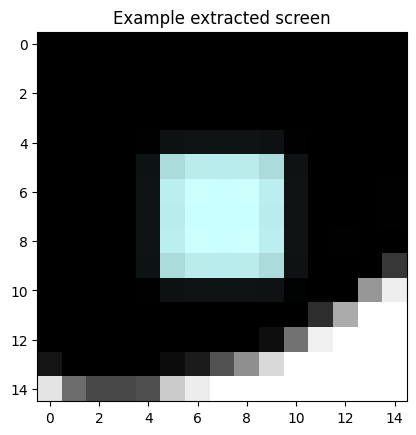

In [6]:
env.reset()

def get_screen():
    screen = env.render().transpose((2, 0, 1))  # transpose into torch order (CHW)
    _, screen_height, screen_width = screen.shape

    # full screen
    # screen = screen[:,:, 520:730]
    
    # area around agent
    # coordinaat van linkerbovenhoek rechthoek
    x_pixel_coo_agent = env._agent_location[0] * env.pix_square_size
    y_pixel_coo_agent = env._agent_location[1] * env.pix_square_size

    x_coo_right_up = x_pixel_coo_agent + 2 * env.pix_square_size
    x_coo_right_down = x_pixel_coo_agent - env.pix_square_size

    y_coo_left_down = y_pixel_coo_agent + 2 * env.pix_square_size
    y_coo_left_up = y_pixel_coo_agent - env.pix_square_size

    # left handed coordinate system
    screen = screen[:,y_coo_left_up:y_coo_left_down, x_coo_right_down:x_coo_right_up]

    

    # Convert to float, rescare, convert to torch tensor (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


plt.figure()
example_screen = get_screen()
print(example_screen.shape)
# print(f"shape of screen: {screen.example_screen}")
plt.imshow(example_screen.cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()


In [7]:
def select_action(state):
    return policy_net(state).max(1)[1].view(1, 1)

In [14]:
action_number_to_direction_mapping = { 0: "right", 1: "down", 2: "left", 3: "up"}
rootdir = './refactor/'

In [15]:
def create_folder_structure():
    for value in action_number_to_direction_mapping.values():
        if not os.path.exists(f"{rootdir}{value}"):
            os.makedirs(f"{rootdir}{value}")

create_folder_structure()

In [16]:
def labelIters(policy_net, n_iters=60):
    
    for iteration in range(n_iters):

        wrapped = HumanRendering(env)

        # Initialize the environment and state
        env.reset()
        wrapped.reset()
        state = get_screen()

        for t in count():
            env.render()
            wrapped._render_frame()

            action = select_action(state)
            _, reward, done, _, _ = env.step(action.item())

            # label state of environment
            plt.figure()
            plt.axis('off')
            plt.imshow(state.cpu().squeeze(0).permute(1, 2, 0).numpy(),interpolation='none')
            action_label = action_number_to_direction_mapping[action.item()]
            plt.savefig('refactor/' + action_label + '/row_' + 
                        str(env._agent_location[0]) +'_col_' + str(env._agent_location[1]) + '.png',bbox_inches='tight', transparent=True, pad_inches=0)

            if not done:
                # 1 beeld
                next_state = get_screen()

            else:
                next_state = None

            # Move to the next state
            state = next_state

            if done or ((t + 1) % 100 == 0):
                print("reset")
                break


    print('Complete')
    wrapped.render()
    wrapped.close()

    env.render()
    env.close()


4
Model loaded


C:\Users\xande\AppData\Local\Temp\ipykernel_21576\518445653.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


reset
Complete


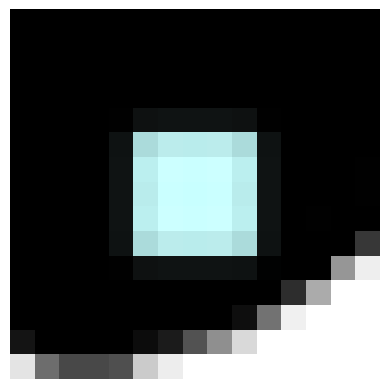

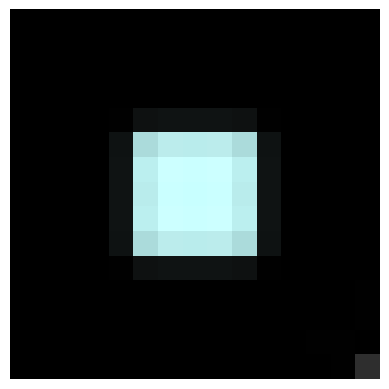

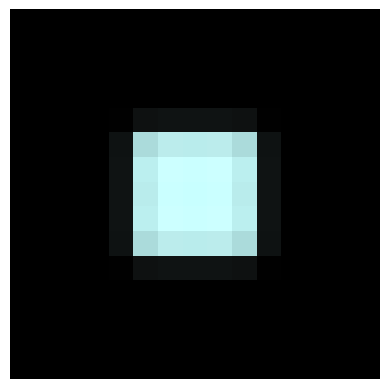

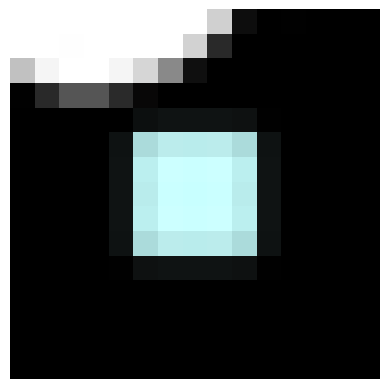

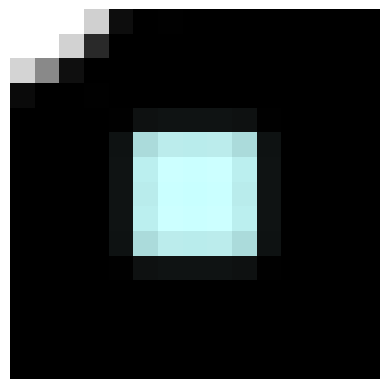

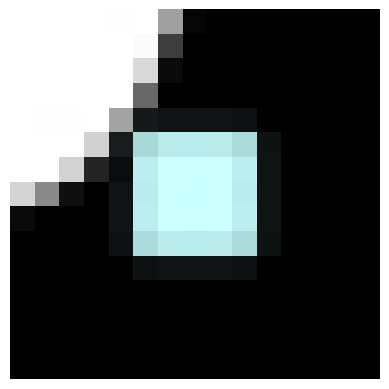

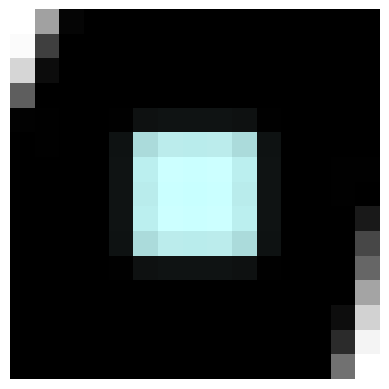

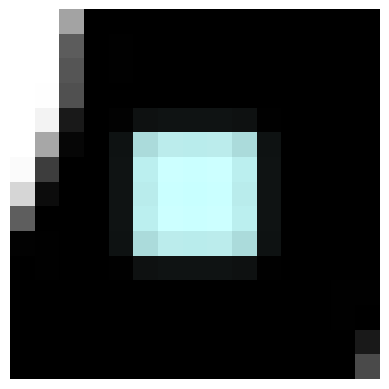

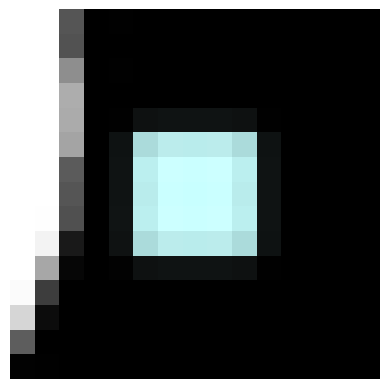

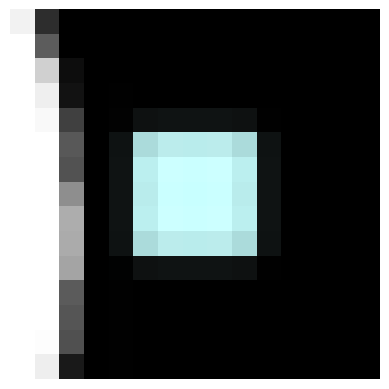

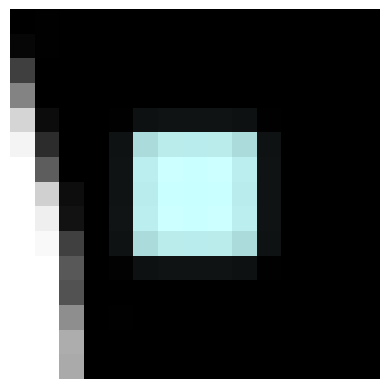

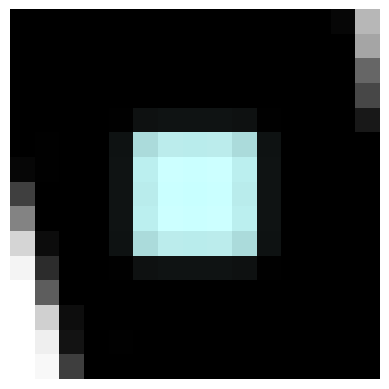

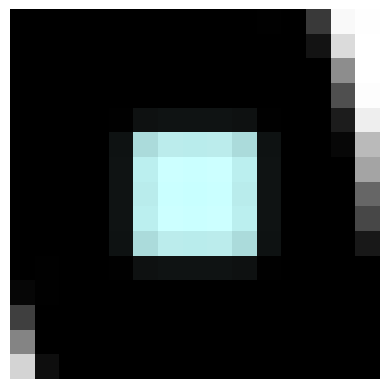

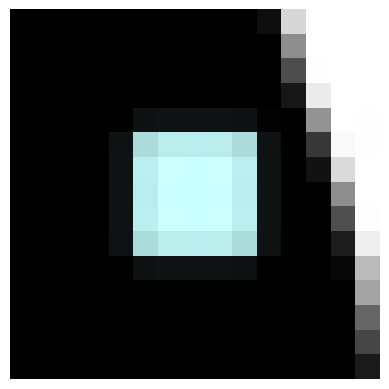

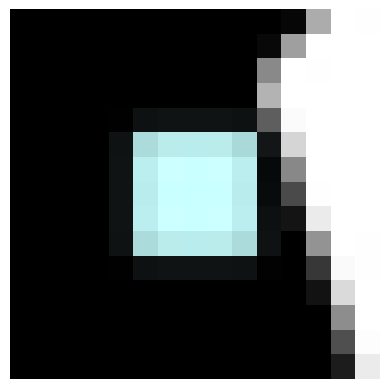

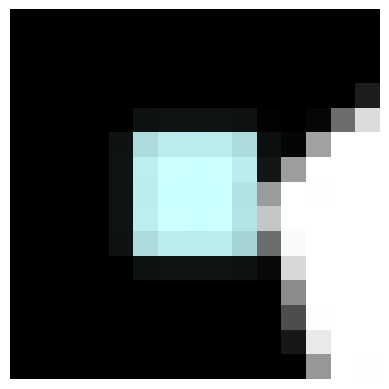

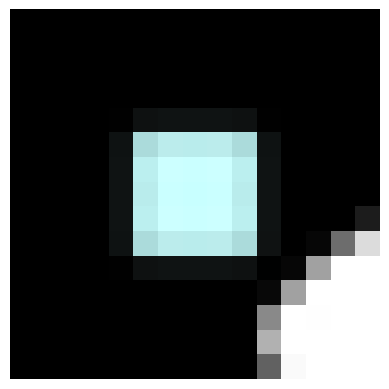

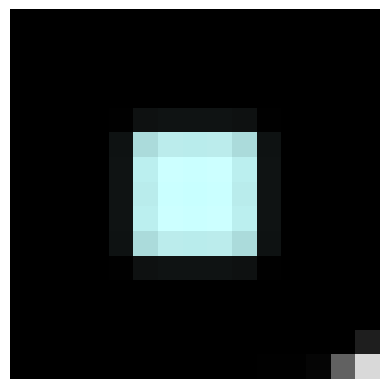

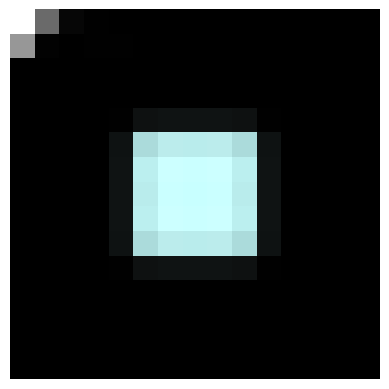

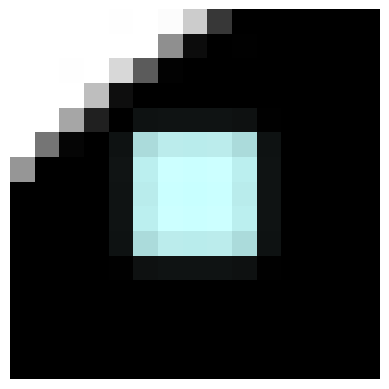

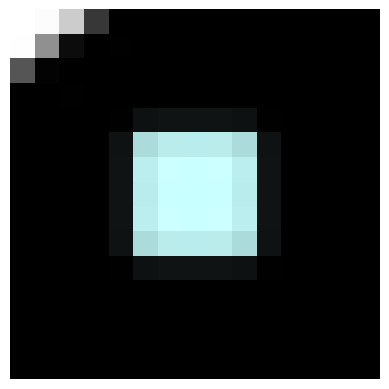

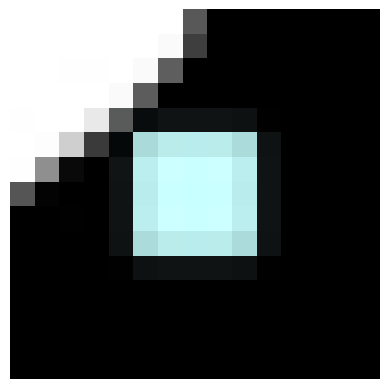

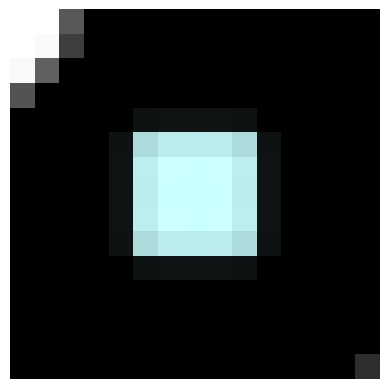

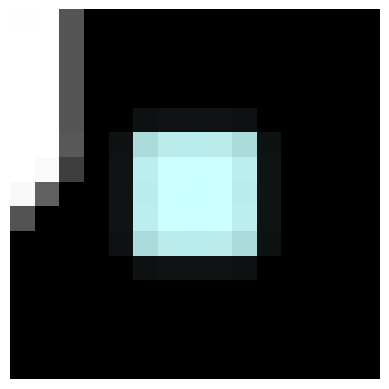

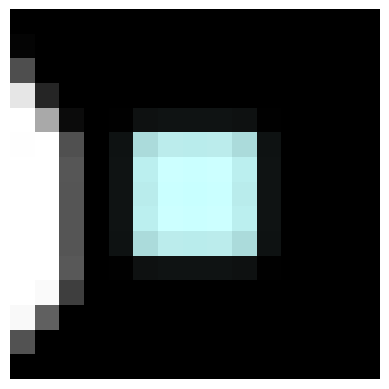

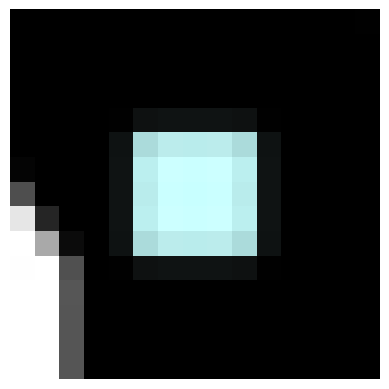

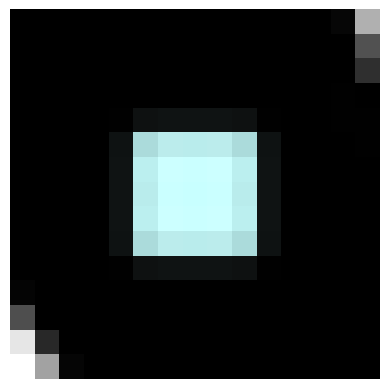

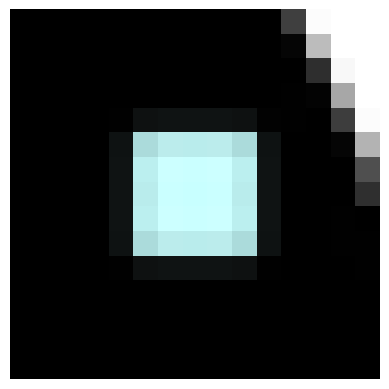

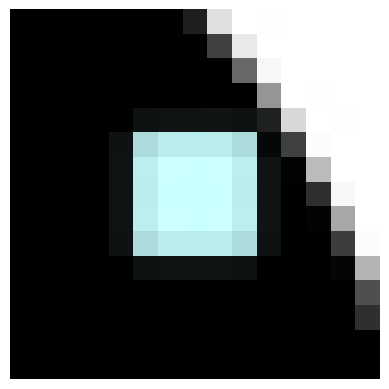

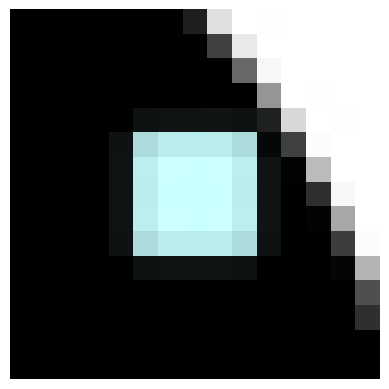

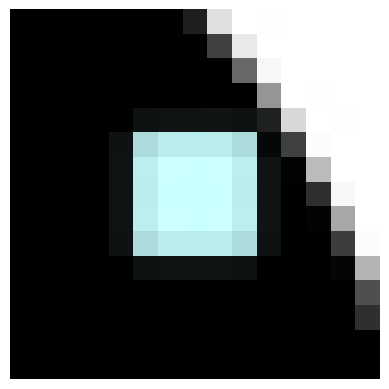

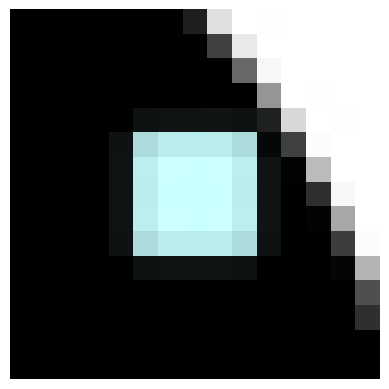

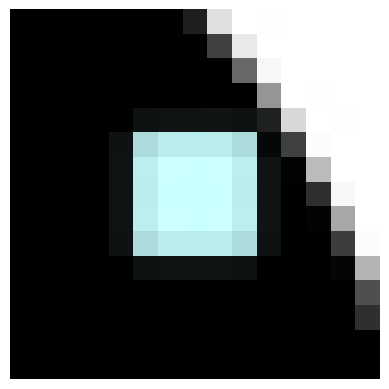

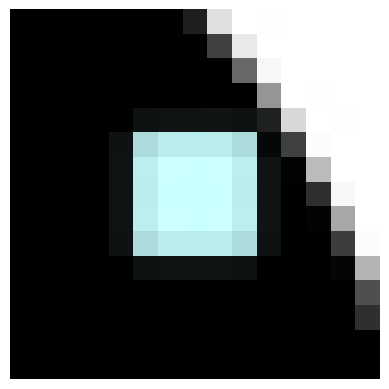

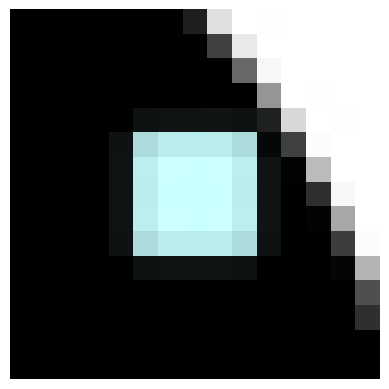

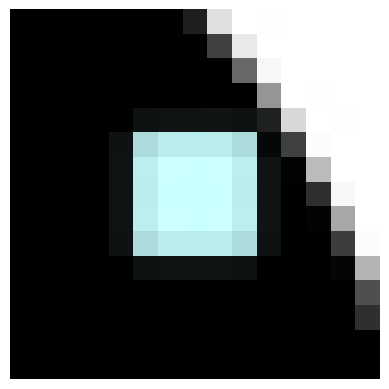

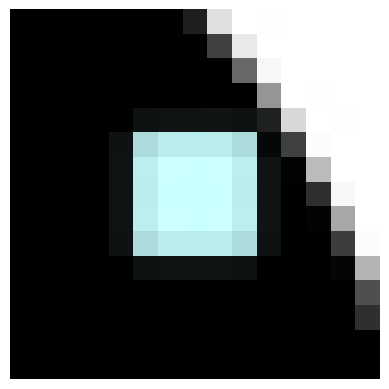

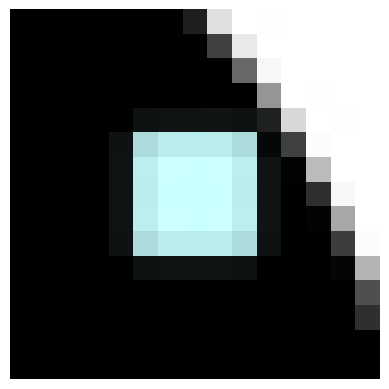

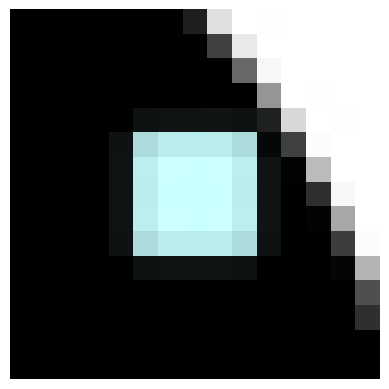

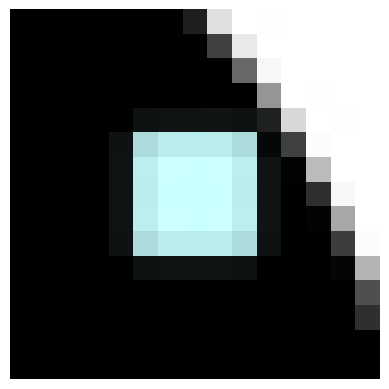

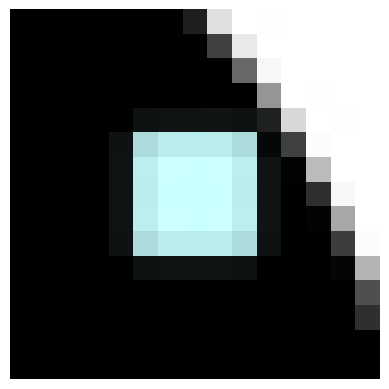

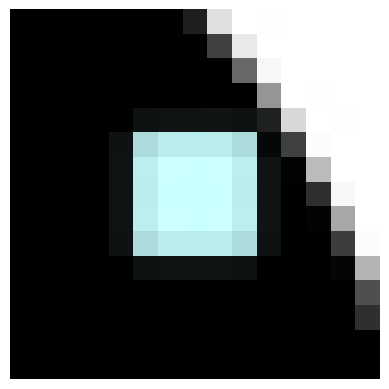

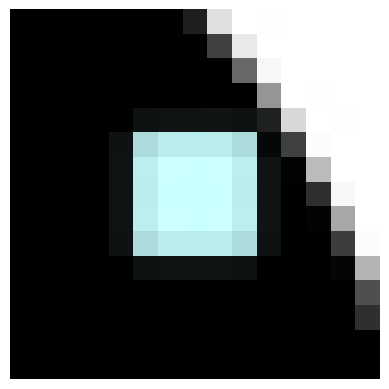

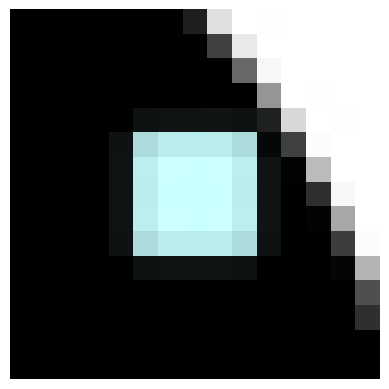

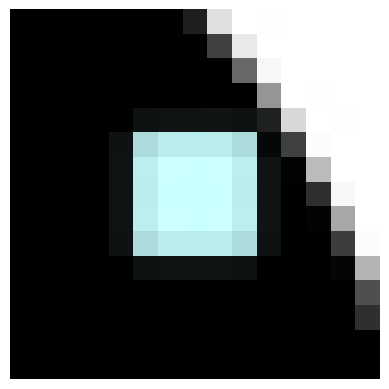

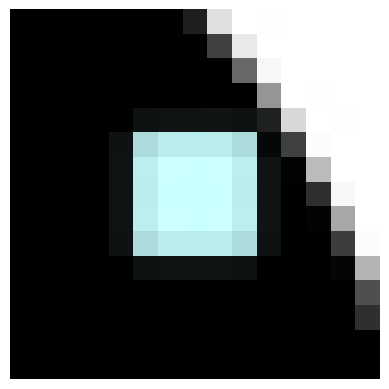

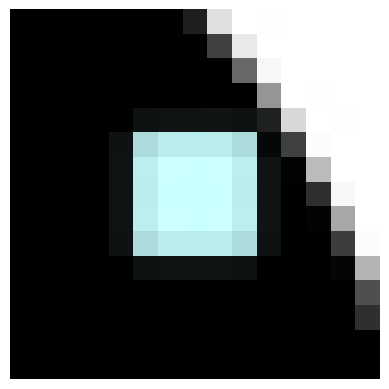

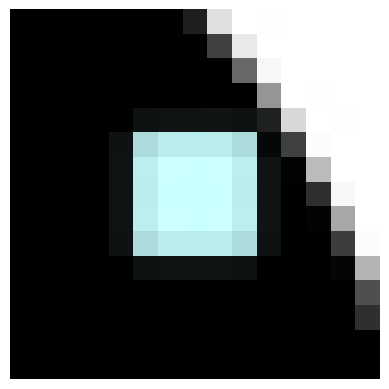

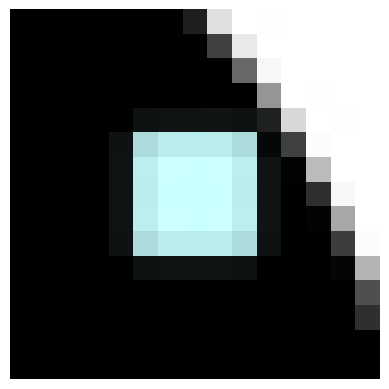

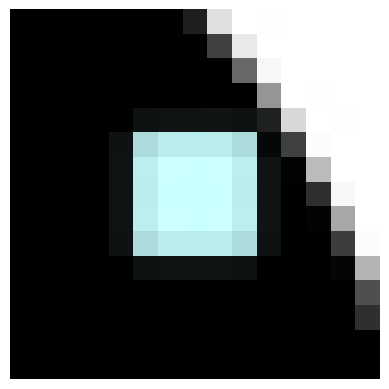

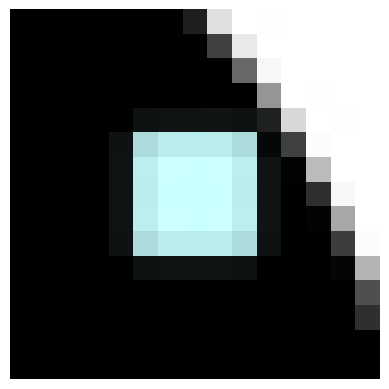

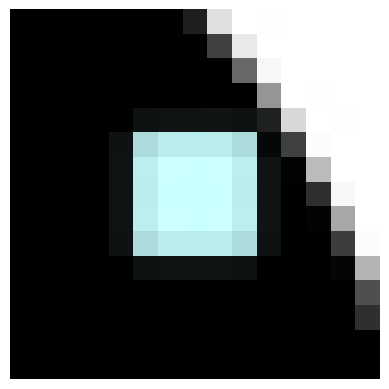

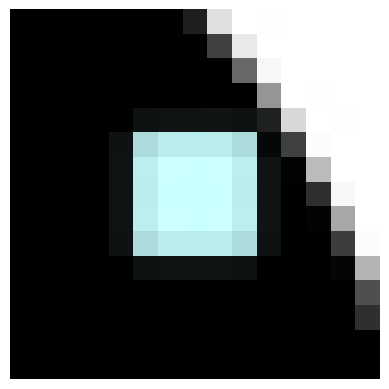

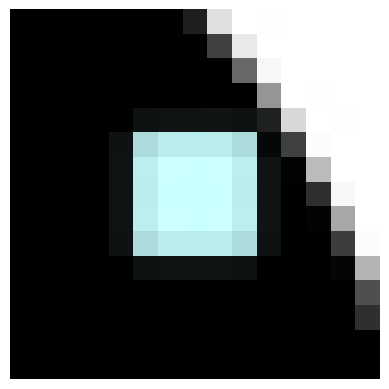

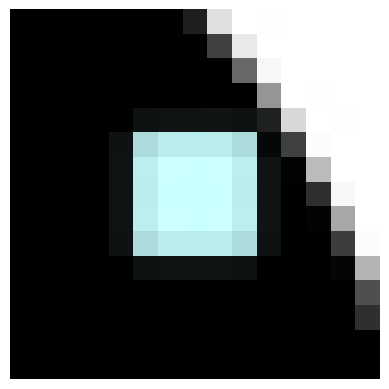

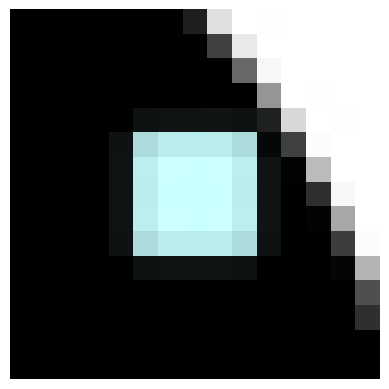

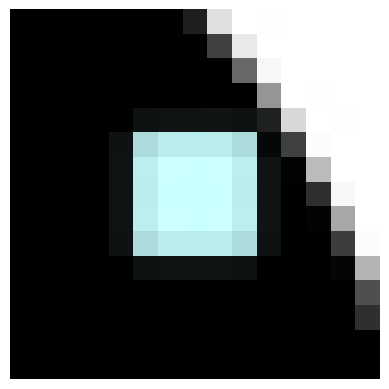

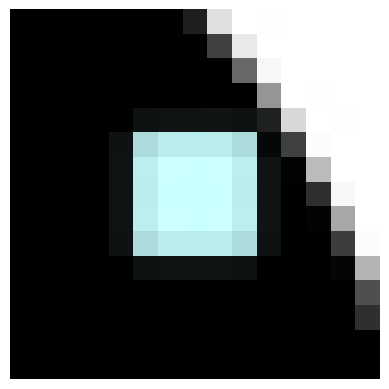

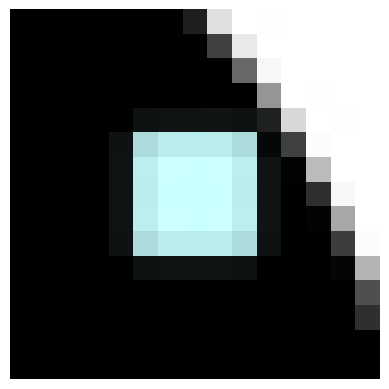

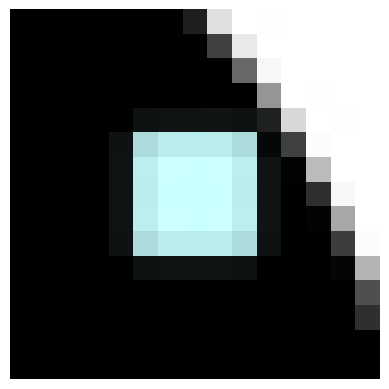

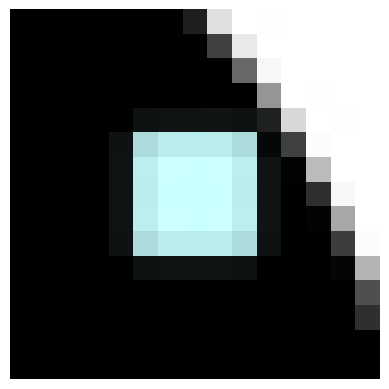

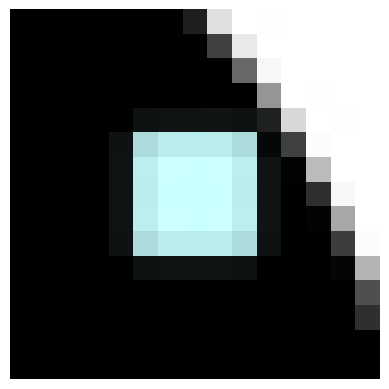

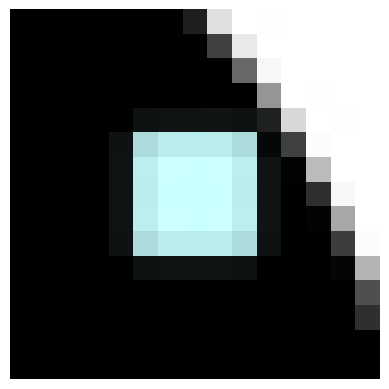

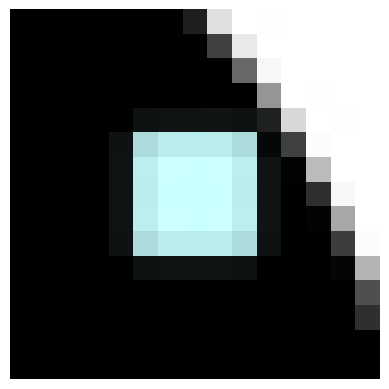

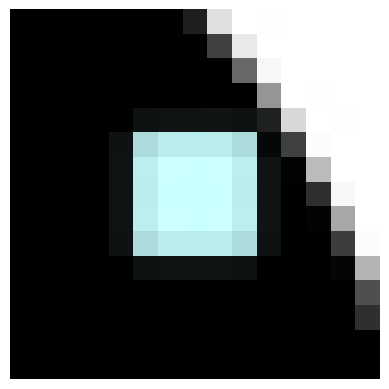

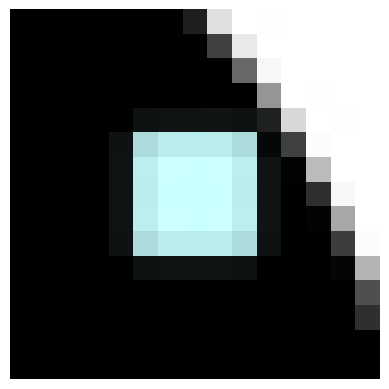

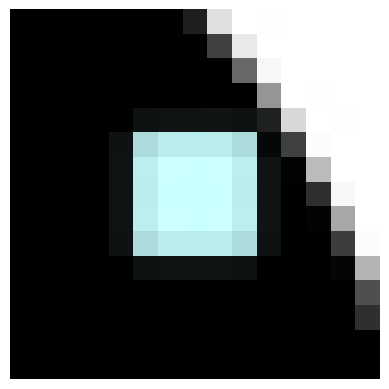

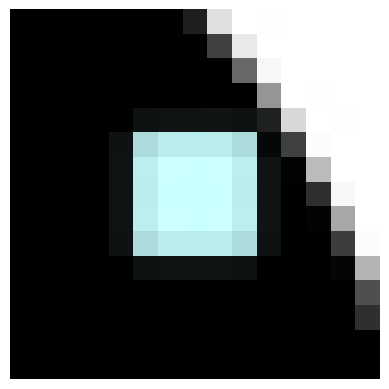

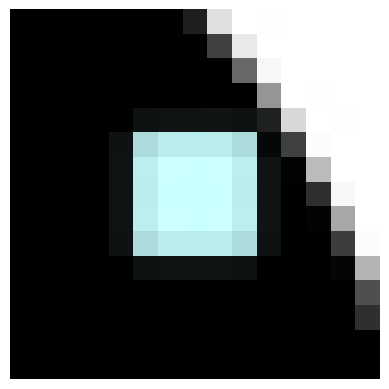

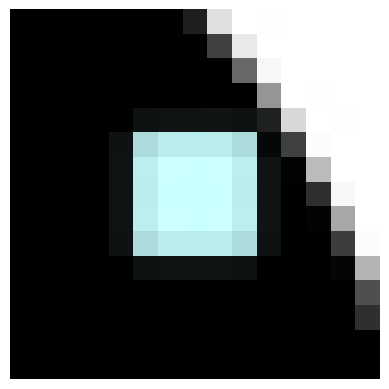

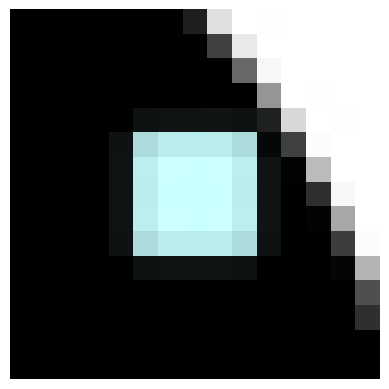

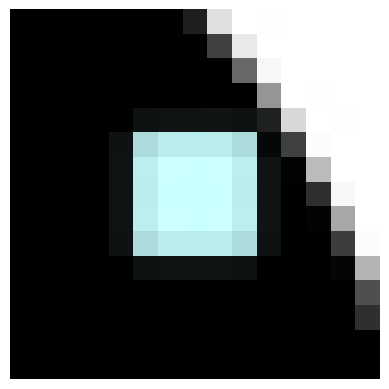

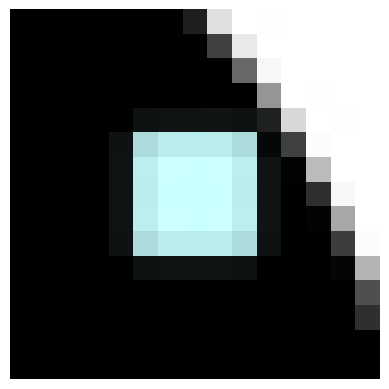

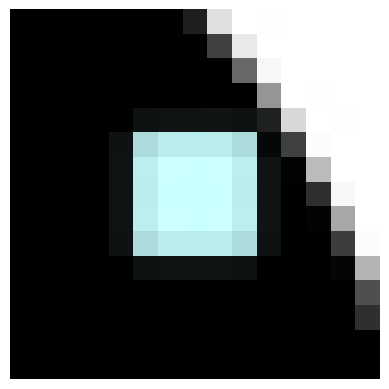

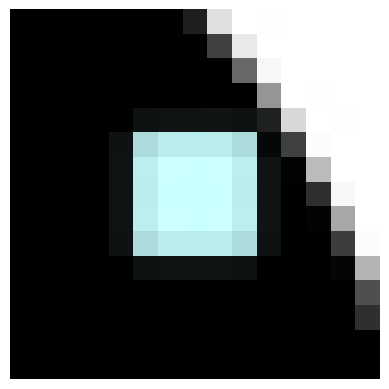

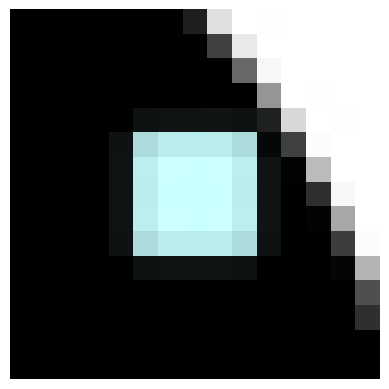

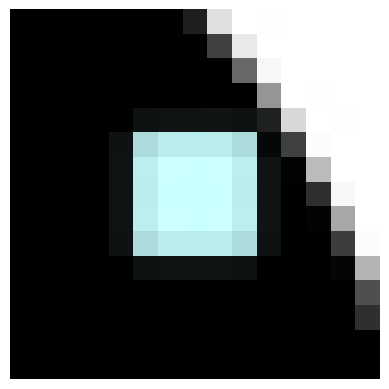

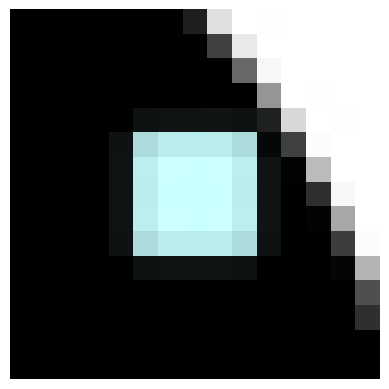

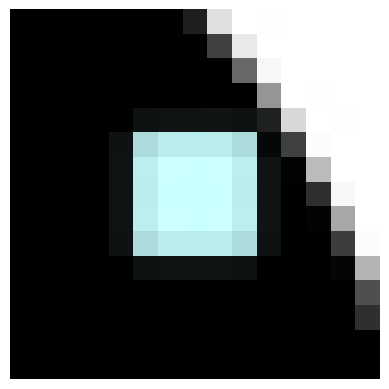

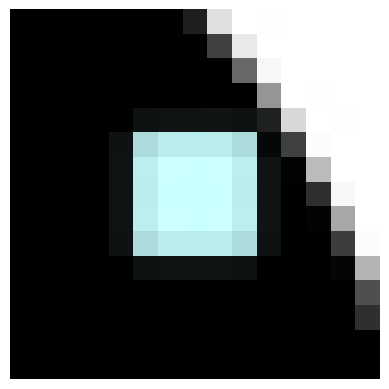

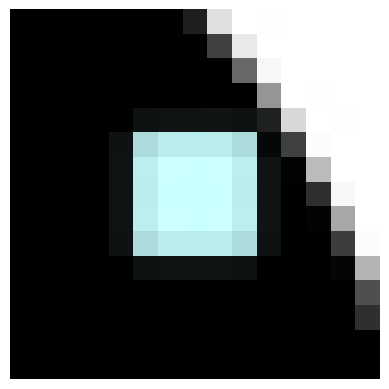

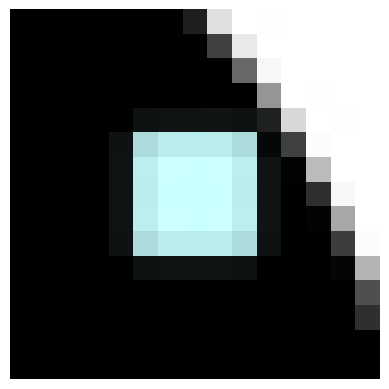

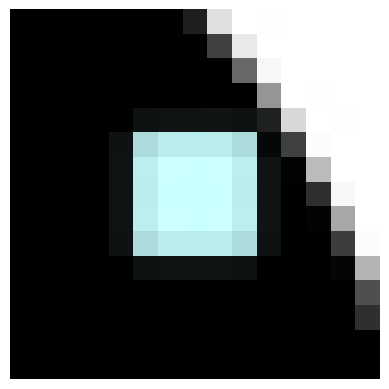

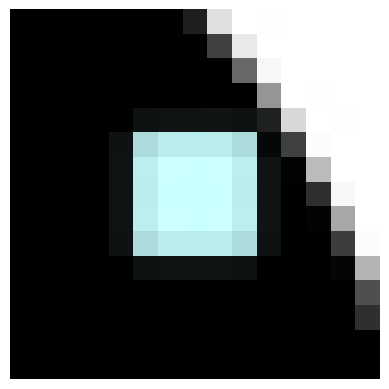

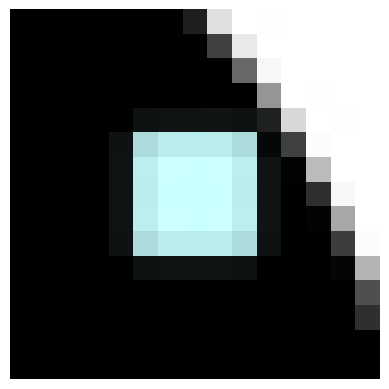

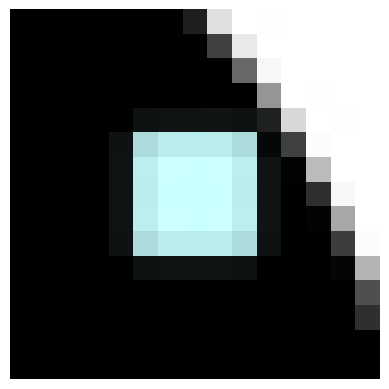

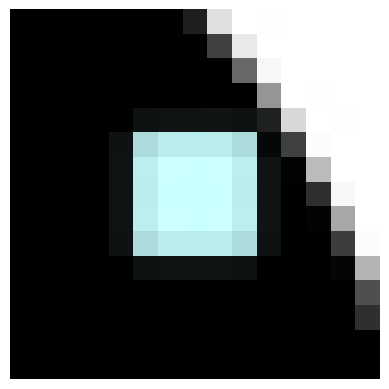

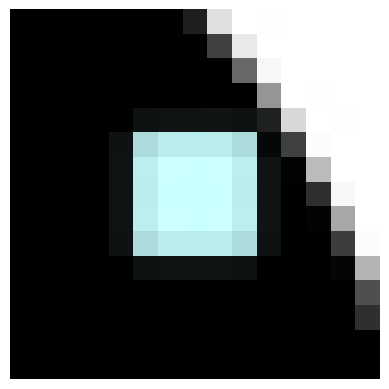

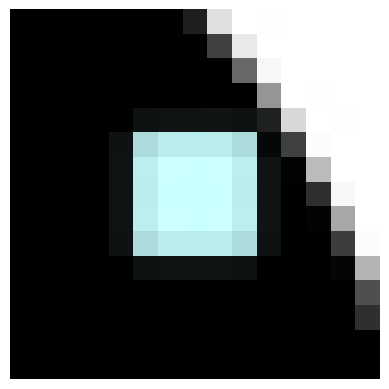

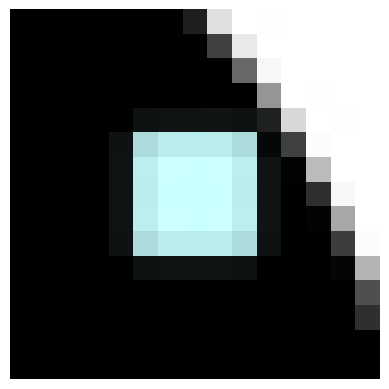

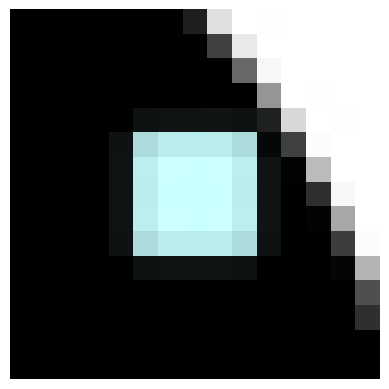

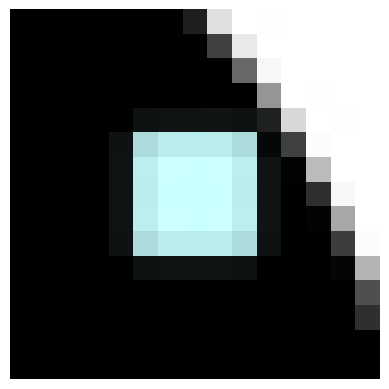

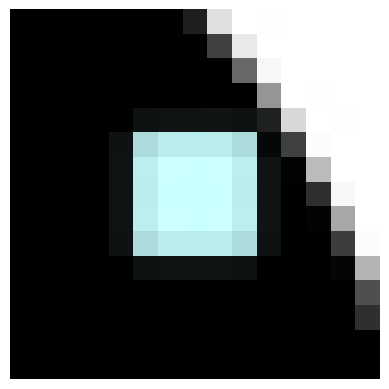

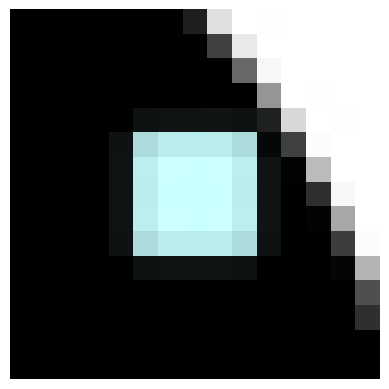

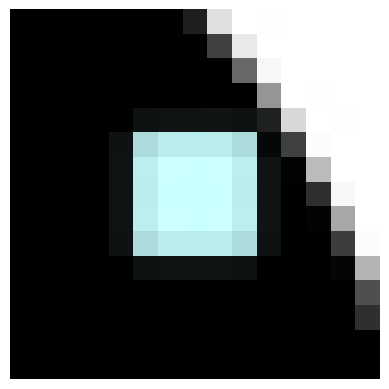

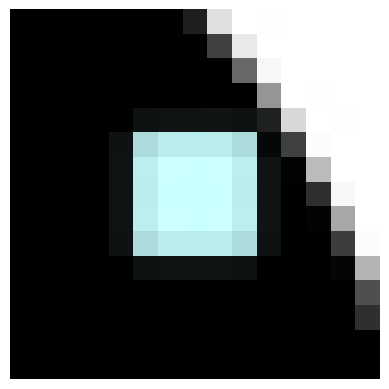

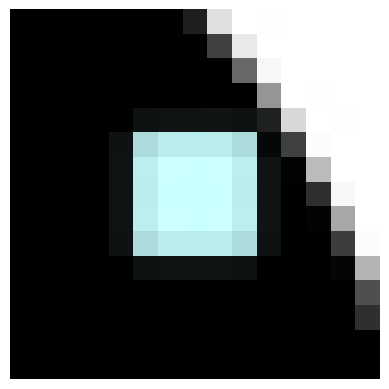

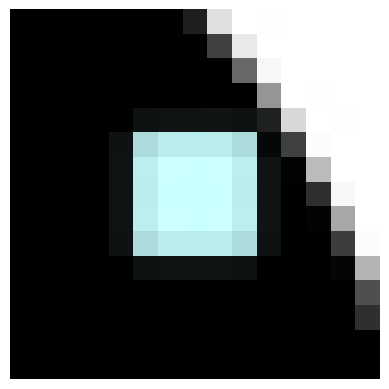

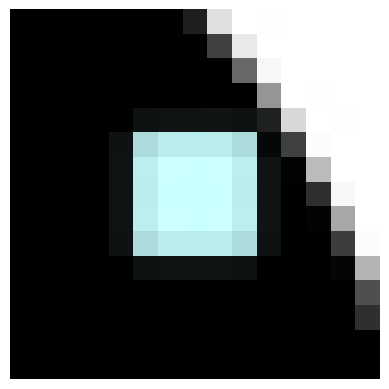

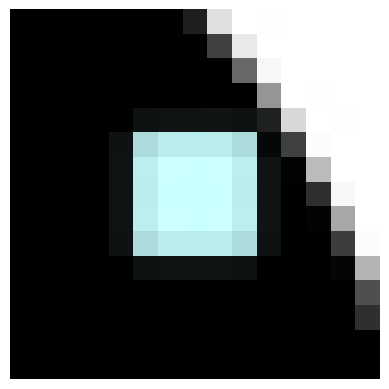

In [17]:
if __name__ == "__main__":

    # Get screen size so that we can initialize layers correctly based on shape
    # returned from AI gym. 

    init_screen = get_screen()
    _, _, screen_height, screen_width = init_screen.shape

    # Get number of actions from gym action space
    n_actions = env.action_space.n
    print(n_actions)
    policy_net = torch.load('./model/test_refactorend.pkl')
    print('Model loaded')
    labelIters(policy_net, n_iters=1)

### Text label file for prototree and file indexing images

In [18]:
images = open(f"{rootdir}images.txt", "w")
image_class_labels = open(f"{rootdir}image_class_labels.txt", "w")

class_label = 0 
line_number = 1
for subdir, dirs, files in os.walk(rootdir):
    location_slash_2 = str(subdir).find('/', 2)
    substr = str(subdir)[location_slash_2+1:]
    # check if substring is empty
    
    if not substr == "":
        for filename in os.listdir(f"{rootdir}" + substr):
            print
            images.write(str(line_number) + " " + filename + "\n")
            image_class_labels.write(str(line_number) + " " + str(class_label) + "\n")
            line_number += 1
    class_label += 1

image_class_labels.close()
images.close()

### Rescale images

In [ ]:
for subdir, dirs, files in os.walk(rootdir):
    location_slash_2 = str(subdir).find('/', 2)
    substr = str(subdir)[location_slash_2+1:]
    if not substr == "":
        for filename in os.listdir(f"{rootdir}" + substr):
            img = cv.imread(f"{rootdir}" + substr + "/" + filename)
            scale_percent = 500 # percent of original size
            width = int(img.shape[1] * scale_percent / 100)
            height = int(img.shape[0] * scale_percent / 100)
            dim = (width, height)

            # resize image
            resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)

            # padden 
            # img = img[...,::-1]
            # npad = ((0, 0), (146, 145), (0, 0))
            # img = np.pad(img, pad_width=npad, mode='constant', constant_values=255)
            # img = img[...,::-1]

            cv.imwrite("f{rootdir}" + substr + "/" + filename, img)         